Ok, in my last post we went through the concept of a sampling distribution using the mean as an example.  But, there is a sampling distribution for any statistic.  In this post I'm going to demonstrate this with what are the two most important sampling distributions in the context of AB testing: the sampling distribution of the difference in means, and the sampling distribution of the difference in proportions.  If you are completely unfamiliar with what a sampling distribution is, have a quick read through my [last post](https://www.a2bofdatascience.com/post/what-is-a-sampling-distribution) first before reading on below.

In [1]:
set.seed(145)
options(tidyverse.quiet=TRUE)
suppressWarnings(library(glue))
suppressWarnings(library(tidyverse))
theme_set(theme_minimal())

# Sampling distribution of the difference in means

Let's assume that you have two populations of users, group A and group B.  Let's further assume that in there are 1 million users in each of these populations.  We can think of group A as the control group -- these are the values for users that we would expect to observe under the status quo. In group B, on the other hand, are the values we would expect to observe under some alternative status, for example if we were to roll out a new feature.  Remember, at this point we are working entirely theoretically, we do not actually observe all of these values for each user (we can of course observe the status qou, but not the alternative, until we actually roll out the new feature).

For the purpose of this example, we'll assume that the values of our metric of interest are normally distributed in each of the populations.  The only difference between the two is that we'll set the mean value for group B to be 2 points higher than group A.  Assuming that you are able to draw a reasonably large sample from the population, and assuming that each draw is independent, the central limits theorem tells us that the shape of the underlying distribution in the population does not matter.  I've written about this in more detail before, see [this post](https://www.a2bofdatascience.com/post/what-is-a-sampling-distribution).

By setting the mean value of group B to be 2 points higher than group A we are saying that the true difference in the population is 2.  When we sample and run an AB test, this is what we are trying to infer.  So, let's see how this works by going through the concept of a sampling distribution of the difference in means.

First, we'll create our two populations with draws from a normal distribution, and plot the resultant histograms.

In [2]:
a = rnorm(1e6)
b = rnorm(1e6, 2, 1)

data = tibble(
    a=a,
    b=b
) %>%
  gather(key='group', value='metric')

The code above gives us a dataframe of shape 2e6x2, or 2 million users with data for one metric.  We also have a grouping variable that indicates which group each observation comes from.  

In [3]:
data %>% head() 
data %>% tail()

group,metric
<chr>,<dbl>
a,0.6869129
a,1.0663631
a,0.5367006
a,1.9060287
a,1.0631596
a,1.3703436


group,metric
<chr>,<dbl>
b,2.761647
b,2.085068
b,1.894433
b,2.538952
b,2.957069
b,1.162222


The histograms are largely identical, the only difference is that group B is centered about 2, whereas group A is centered about 0:

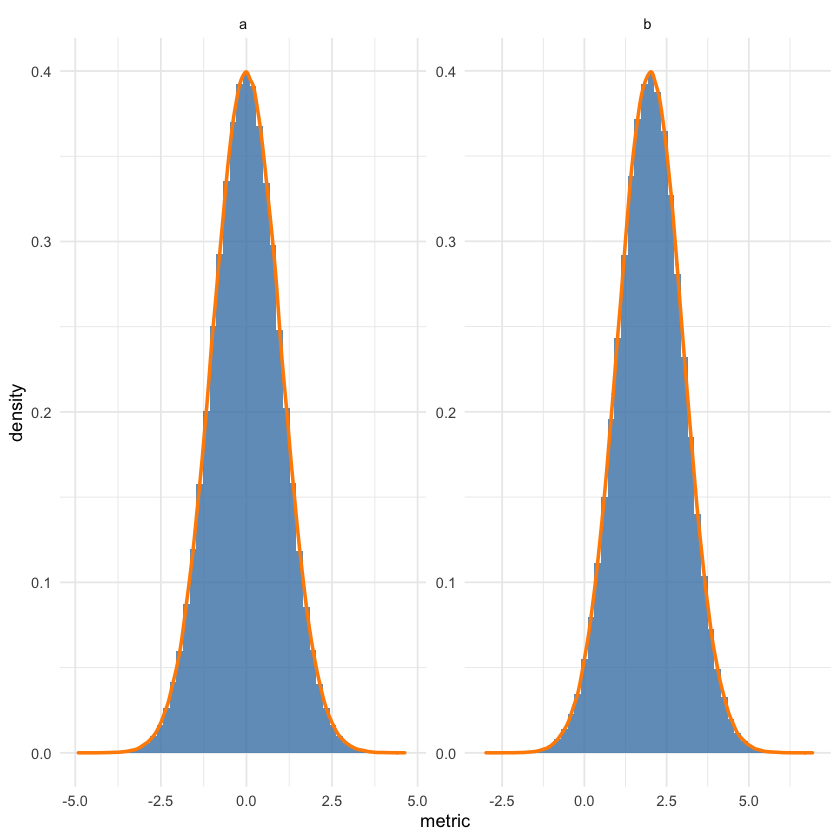

In [4]:
data %>%
  ggplot(aes(x=metric)) + 
  geom_histogram(aes(y=..density..,), position='dodge', fill='steelblue', alpha=0.8, bins=50) + 
  geom_density(color='darkorange', size=1, alpha=.7) +
  facet_wrap(~group, scales='free')

## An AB test

Now that we have our two populations, let's run an AB test!  We pull a sample of 1000 users from each of our two groups.  We can then calculate the difference in means between these two groups:

In [5]:
a_sample = a %>% as_tibble() %>% sample_n(1000) %>% pull(value)
b_sample = b %>% as_tibble() %>% sample_n(1000) %>% pull(value)

mean(b_sample) - mean(a_sample)

[1] 1.962473

There it is, in our first AB test 

Now, from here we would run a t-test to determine if the difference we observed was statistically significant.  When we conduct a t-test, we want to infer one thing, what is the true difference in means in the population.  What a t-test gives us is an estimate of this true difference given the values we observe in our population, and an estimate of the variability in that observation given the sample size and variance observed in the samples.  You get a few other things as well, such as a confidence interval and a p-value, but these are simply functions of the estimated sampling distribution, which is represented by the observed difference in means and standard error.  

In [6]:
mean_a = mean(a_sample)
sd_a = sd(a_sample)
n_a = length(a_sample)
mean_b = mean(b_sample)
sd_b = sd(b_sample)
n_b = length(b_sample)

# t test
diff = mean_b - mean_a
se = sqrt(sd_a^2 / n_a + sd_b^2 / n_b)

list(diff=diff, se=se)

$diff
[1] 1.962473

$se
[1] 0.04362273

The observed difference in this AB test is 1.96, which is close to the true value of 2 that we defined initially.  But where does the standard error value of 0.04 come from?  This represents the *standard deviation of the sampling distribution*.  We can continue drawing random samples from our group A and group B populations to demonstrate this.  First, a quick helper function to facilitate this -- it simply draws a sample from group A and a sample from group B and returns the observed difference in means:

## Many AB tests - simulating the sampling distribution

In [7]:
ab_diff_mean = function(a, b, sample_size=1000){
    a_sample = as_tibble(a) %>% sample_n(sample_size)
    b_sample = as_tibble(b) %>% sample_n(sample_size)
    mean(b_sample$value) - mean(a_sample$value)
}

Now we can call this function a large number of times to get an approximation of the sampling distribution of the difference in means. Here are the results from the first six simulated AB tests:

In [8]:
diffs_in_means = replicate(5000, ab_diff_mean(a, b, 1000)) %>% as.double() %>% as_tibble() %>% rename(dif=value)

diffs_in_means %>% head()

dif
<dbl>
2.065388
1.986764
2.064452
2.008970
2.021868
1.969523


Some values are below the true value of 2, and some are above.  And if we plot the distribution of all 5000 simulated AB tests we get this:

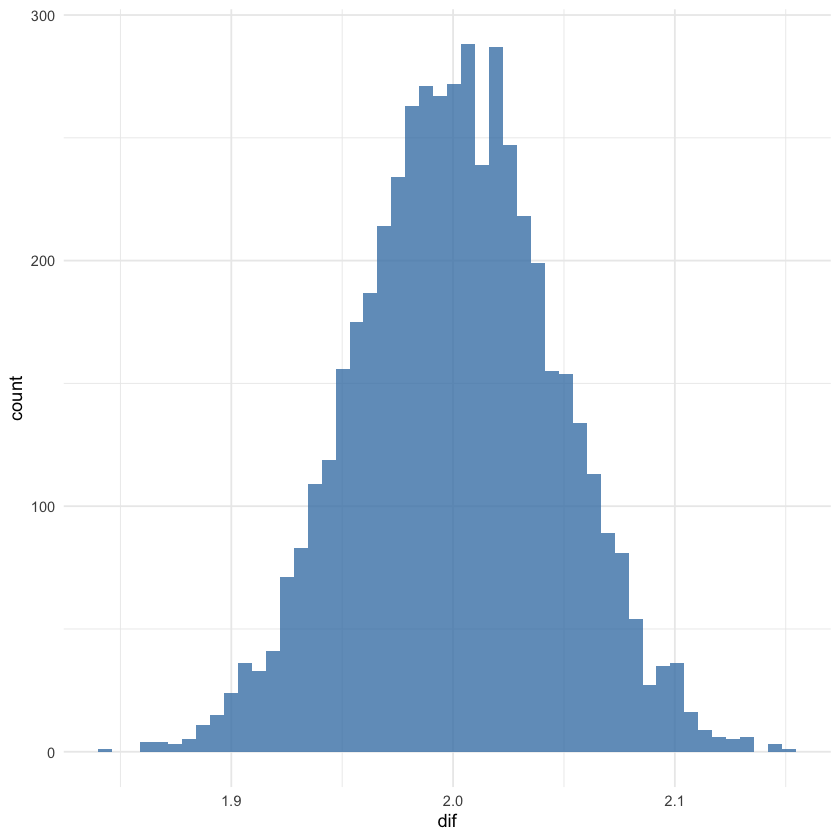

In [9]:
diffs_in_means %>%
  ggplot(aes(x=dif)) + 
  geom_histogram(fill='steelblue', bins=50, alpha=0.8)

A normal distribution centered about 2.  In other words, while each indivdidual AB test is unlikely to give us an estimated difference exactly equal to the true difference in the population, the mean of the sampling distribution will be centered about the true value.  The spread of the observations, or the variance of the sampling distribution, is directly related to the variance in the observed samples, and the sample size.  More observations in each sample, less variance in the sampling distribution.  It is this variance that we estimate when we calculate the standard error of the estimate in a t-test.  

Remember the estimated standard error from our first t-test? It was 0.044.  And the standard deviation of the distribution of the 5000 simulated AB tests, our approximated sampling distribution? 0.045

In [10]:
print(se)
print(sd(diffs_in_means$dif))

[1] 0.04362273
[1] 0.04459227


# Sampling distribution of the difference in p

The second sampling distribution that I want to write about is the difference in proportions.  The nature of dichotomous data (data that takes on values of 0 or 1) makes means estimating the sampling distribution of the difference in p is quite different to the t-test we used above.  But, it is in fact just an example of a difference in means.  Just don't ever do a t-test with dichotomous data... 



Ok, like before, let's assume we have two user populations, group A and group B.  We're interested in a dichotomous metric, such as, did the user login to the platform today?  That means that a user can score a 0 or 1, no other values are valid.  We'll set the true proportion in group A to 0.3 and the true proportion in group B to 0.5.  In other words, there is a 20 percentage point difference between the two groups in the percentage of each group that logs in on a given day.  

Here's the two populations visualized:

In [11]:
a_population = rbinom(1e6, 1, 0.3)
b_population = rbinom(1e6, 1, 0.5)

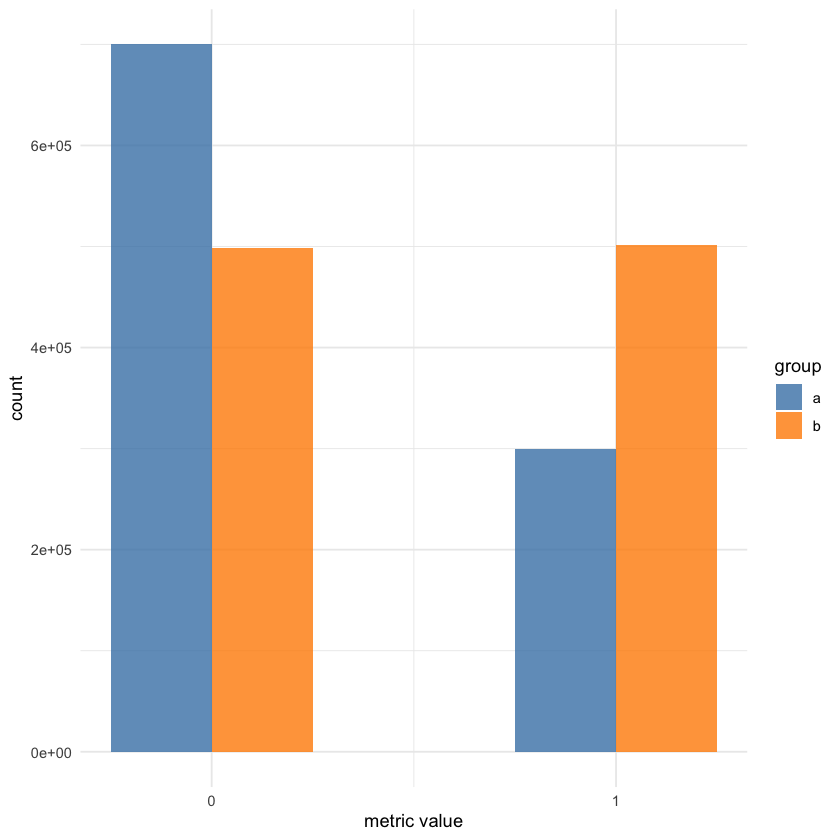

In [12]:
prop_data = tibble(
    a=a_population,
    b=b_population
) %>% 
  gather(key='group', value='metric value')

prop_data %>%
  ggplot(aes(x=`metric value`, fill=group)) + 
  geom_histogram(position='dodge', binwidth=0.5, alpha=0.8) +  
  scale_fill_manual(values=c('steelblue', 'darkorange')) + 
  scale_x_continuous(breaks=c(0, 1), labels=c(0, 1))

Now, we can sample from these two populations and simluate an AB test:

In [13]:
a_sample = a_population %>% as_tibble() %>% sample_n(1000) %>% pull(value)
b_sample = b_population %>% as_tibble() %>% sample_n(1000) %>% pull(value)

In [14]:
a_prop = mean(a_sample)
b_prop = mean(b_sample)
ab_prop_diff = b_prop - a_prop

# binomial proportions test, use prop.test()
a_prop_n = length(a_sample)
b_prop_n = length(b_sample)
ab_prop_se = sqrt((a_prop*(1-a_prop))/(a_prop_n) + (b_prop*(1-b_prop))/(b_prop_n))
ub = ab_prop_diff + ab_prop_se * 1.96
lb = ab_prop_diff - ab_prop_se * 1.96

In [15]:
ab_prop_diff

[1] 0.195

In [16]:
ab_prop_se

[1] 0.02137772

In our small sample of 1000 users each in samples A and B that were drawn from our larger populations of 1 million users each, the estimated difference in proportions was 0.195.  In other words, in sample B we observed ~20 percentage points more login than in sample A.  The standard error that we estimated, which is calculated as:


<h3><center> $\hat{\rho} = \bar{p}$ </center></h3>
    
<center> And </center>
    
<h3><center> $se_{\hat{\rho}} = \sqrt{ \frac{p_a \cdot (1-p_a)}{n_a} + \frac{p_b \cdot (1-p_b} {n_b} }$ </center></h3>

This is the theoretical variance in the sampling distribution given the observed proportions and the number of users in each sample.  How does this line up with a simulated sampling distribution?  We can find out by simulating 5000 AB tests and analyzing the results:

In [17]:
prop_samp_dist = replicate(5000, ab_diff_mean(a_population, b_population, sample_size=1000))

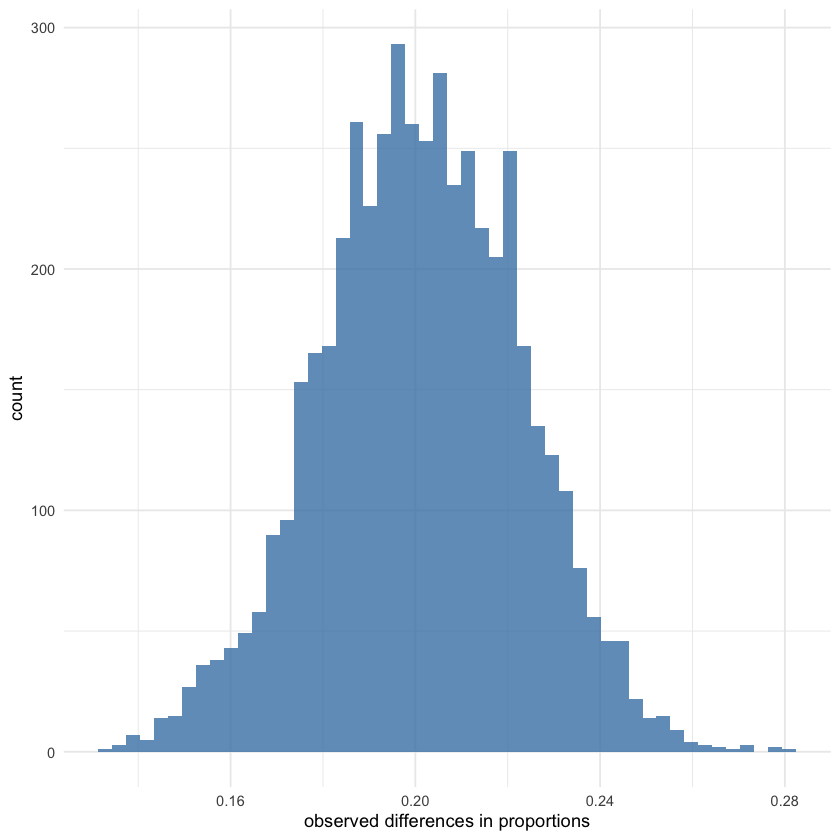

In [21]:
tibble(
    proportions=prop_samp_dist
) %>%
  ggplot(aes(x=proportions)) + 
  geom_histogram(fill='steelblue', alpha=0.8, bins=50) + 
  xlab('observed differences in proportions')

The simulated sampling distribution is approximately normal, which we would expect **so long as the proportions are not close to 0 or 1, or the sample size is large**.  More samples in the sampling distribution would lead to a smoother normal distribution.  And, the sampling distribution is centered about 0.20102, which is nearly bang on the true difference of 0.2:

In [19]:
mean(prop_samp_dist)

[1] 0.20102

And the standard deviation of the simulated sampling distribution is nearly identical to the standard error that we calculated parametrically using our first sample:

In [20]:
cat(paste0('standard deviation of sampling distribution: \t',  round(sd(prop_samp_dist), 4), 
           '\n parametric standard error: \t\t\t', round(ab_prop_se, 4)))

standard error of sampling distribution: 	0.0217
 parametric standard error: 			0.0214